# Workpackage: Data engineering

Research Question:
**"How far can we simplify the input data to be still able to distinguish between Hand, Paper, and Scissors?"**

Research Answer:
We can simplify input pictures through by converting them to greyscale and reducing the resolution. Both methods can be used without loosing much of the needed elements. Additionaly we can blur the images, to remove details and only get rough shapes and then use segmentation methods like otsu to get a binary image with the shape of the hand. On simple and clear input images, this can work so good, that with the calculation of histograms one could distinguish the gestures without maschine learning at all. The drawbacks are, that one relies heavily on the selection of the segmentation method and thus needs to be carefully chosen. Another problem shows the segmentation of more complex data. There the segmentation with basic methods have shown to be very incorrect and partwise not usefull at all. But this could also be due to the fact that the implemented otsu method is a global threshold segmentation method, which is not siuted for this usecase. If one has a good segmentation method for this use case, one could as also implemented cut the background out, so that the ML algorithm just has to distinguish between face and hand if the segmentation method lacks of that capability.
**All in all the simplest robust image we were able to generate, which could optimize the training robustly is the blurred greyscale image, which has a reduced resolution. Further evaluation needs to be done if the blurring really benefits the training.**

In [4]:
from scipy.ndimage.filters import gaussian_filter
import os, random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


def segment_otsu(img):
    bins_num = 256


    # Get the image histogram
    hist, bin_edges = np.histogram(img, bins=bins_num)

    # Get normalized histogram if it is required

    hist = np.divide(hist.ravel(), hist.max())

    # Calculate centers of bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

    # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]

    # Get the class means mu0(t)
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Get the class means mu1(t)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    # Maximize the inter_class_variance function val
    index_of_max_val = np.argmax(inter_class_variance)

    threshold = bin_mids[:-1][index_of_max_val]
    print("Otsu's algorithm implementation thresholding result: ", threshold)
    result = np.zeros_like(img)
    result[img > threshold] = 255
    result[img <= threshold] = 0

    return result

def lower_resolution_image (image):
    return image.resize((80,60))

def blur_image(image):
    return gaussian_filter(image, sigma=1.5)


def get_data():
    dir = "../Dataset/Rock_Paper_Sissors_Photos/train/scissors"
    file = random.choice(os.listdir(dir))
    path = os.path.join(dir, file)
    print(path)
    original_image = Image.open(path)
    greyscale_image = Image.open(path).convert('L')  # convert to grayscale

    return original_image, greyscale_image

def crop_image(original, image):
    summation_row_array = np.apply_along_axis(sum,axis=0,arr=image)
    summation_column_array = np.apply_along_axis(sum,axis=1,arr=image)
    delete_indices = []
    max_row_value = 0
    for index in range(len(summation_row_array)):
        if summation_row_array[index] == max_row_value:
            delete_indices.append(index)
        else:
            break

    for index in range(len(summation_row_array)-1,-1,-1):
        if summation_row_array[index] == max_row_value:
            delete_indices.append(index)
        else:
            break
    original = np.delete(original,delete_indices,axis=1)
    image = np.delete(image,delete_indices,axis=1)

    delete_indices = []
    max_column_value = 0
    for index in range(len(summation_column_array)):
        if summation_column_array[index] == max_column_value:
            delete_indices.append(index)
        else:
            break

    for index in range(len(summation_column_array)-1,-1,-1):
        if summation_column_array[index] == max_column_value:
            delete_indices.append(index)
        else:
            break
    original = np.delete(original,delete_indices,axis=0)
    image = np.delete(image,delete_indices,axis=0)

    return original, image

def delete_background(original, segmentation):
    original[segmentation == 0] = 255
    return original

def visualize_greyscale(image, name):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.imshow(image, cmap=plt.cm.gray)
    #ax.set_title(name)
    ax.axis('off')

def visualize_image(image,name):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.imshow(image)
    ax.set_title(name)
    ax.axis('off')

def create_histogram(image):
    column_data = np.zeros(image.shape[0])
    for column in range(image.shape[0]):
        column_data[column] = np.sum(image[column])
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(column_data, range(len(column_data)))
    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.set_title('y plot')
    ax.axis('off')
    row_data = np.zeros(image.shape[1])

    for row in range(image.shape[1]):
        row_data[row] = image.sum(axis=0)[row]
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(range(len(row_data)), row_data)
    ax.set_title('x plot')
    ax.axis('off')


In [5]:
def segment_simple_use_case():
    original, greyscale = get_data()
    low_resolution = lower_resolution_image(greyscale)
    blurred = blur_image(low_resolution)
    segmented = segment_otsu(blurred)
    cropped_original, cropped = crop_image(low_resolution, segmented)
    background_deletion = delete_background(cropped_original, cropped)
    create_histogram(cropped)

    visualize_image(original,"Original image")
    visualize_greyscale(greyscale, "Grayscaling")
    visualize_greyscale(low_resolution, "Resolution reduction")
    visualize_greyscale(blurred, "Blurring")
    visualize_greyscale(segmented, "Segmentation")
    visualize_greyscale(cropped, "Centring and zooming in")
    visualize_greyscale(background_deletion, "original without background")



../Dataset/Rock_Paper_Sissors_Photos/train/scissors/glu_116.png
Otsu's algorithm implementation thresholding result:  116.07421875


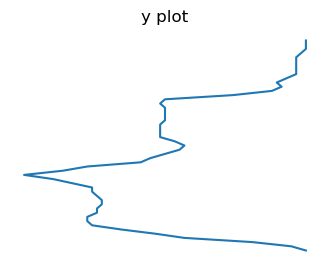

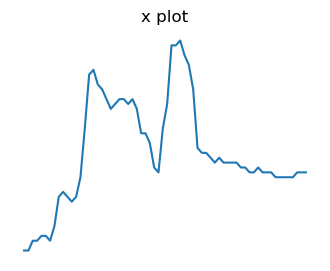

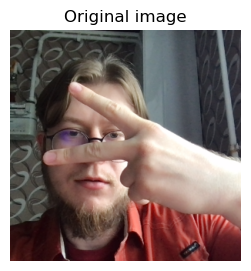

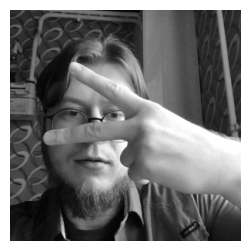

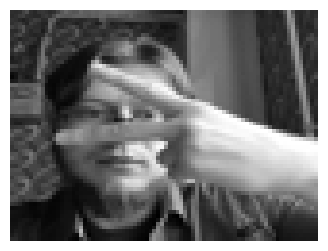

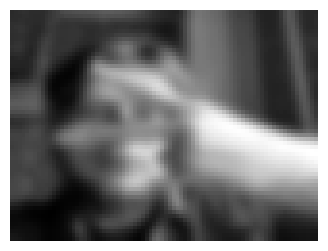

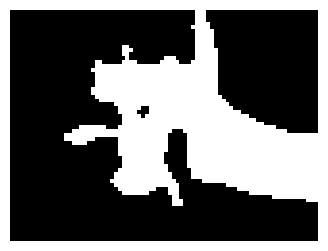

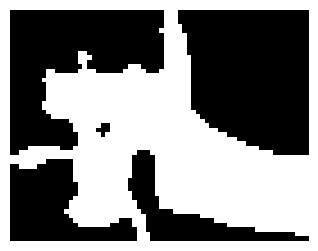

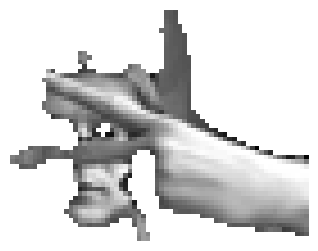

In [6]:
segment_simple_use_case()

# Workpackage: Model Engineering

Research Question:
**Can we get a more robust system by splitting the image recognition into more specific subtasks? i.e. using transfer learing**

Research Answer:
The motivation/reason behind using transfer learning is, that we noticed that the training dataset matches neither our validation dataset nor our custom dataset, which results in a bad performance. Problem is that the validation and test dataset are very divers, while our training dataset consists of many very similar photos. We concluded that either we create our own training dataset, which will be time consuming and runs into the problem, that the unknown training dataset will be different again and thus running in a similar problem. The approach to solve that problem is to use a pretrained model that can segment hands from everything else in the background and by that making the pictures in the different datasets more similar to each other. By that in our hypothesis the performance shall improve noticably. Unfortunatly we ran out of time finding such a pretrained model. The ones we found did not hold what they promised and were not robust at all, and others would we need to train ourselfes, which would require days and lots of energy.
**In summary we tried using transfer learning to improve the performance, but were stopped because we could not find a suiting pretrained model.**

In [7]:
import glob
import cv2

def readin_data(path_array, label):
    images = []
    for path in path_array:
        for filename in glob.glob(path):
            image = cv2.imread(filename)
            im = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),(80,60),interpolation = cv2.INTER_AREA)
            images.append(im)
    label_array = np.full(len(images),label)
    return images,label_array

In [8]:
from tensorflow.keras import utils as us

lable_tensor = us.to_categorical([0, 1, 2], num_classes=3)

def lookup_nominal(nominal):
    str_labels = ('Rock','Paper','Scissors')
    return str_labels[nominal]

In [9]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



Total images: 9932


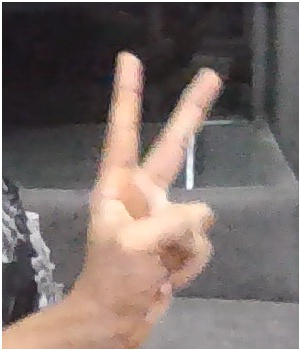

In [10]:
data_dir = pathlib.Path('../Dataset/structured_data')
validation_dir = pathlib.Path('../Dataset/validation_set')
image_count = len(list(data_dir.glob('*/*')))
print("Total images: " +str(image_count))

rock_images = list(data_dir.glob('rock/*'))
paper_images = list(data_dir.glob('paper/*'))
scissors_images = list(data_dir.glob('scissors/*'))

PIL.Image.open(str(scissors_images[1]))

In [308]:
batch_size = 32
img_height = 60
img_width = 60


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    validation_split=0.9999,
    subset="validation",
    seed=123,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 9931 files belonging to 3 classes.
Using 7945 files for training.
Found 151 files belonging to 3 classes.
Using 150 files for validation.
['paper', 'rock', 'scissors']


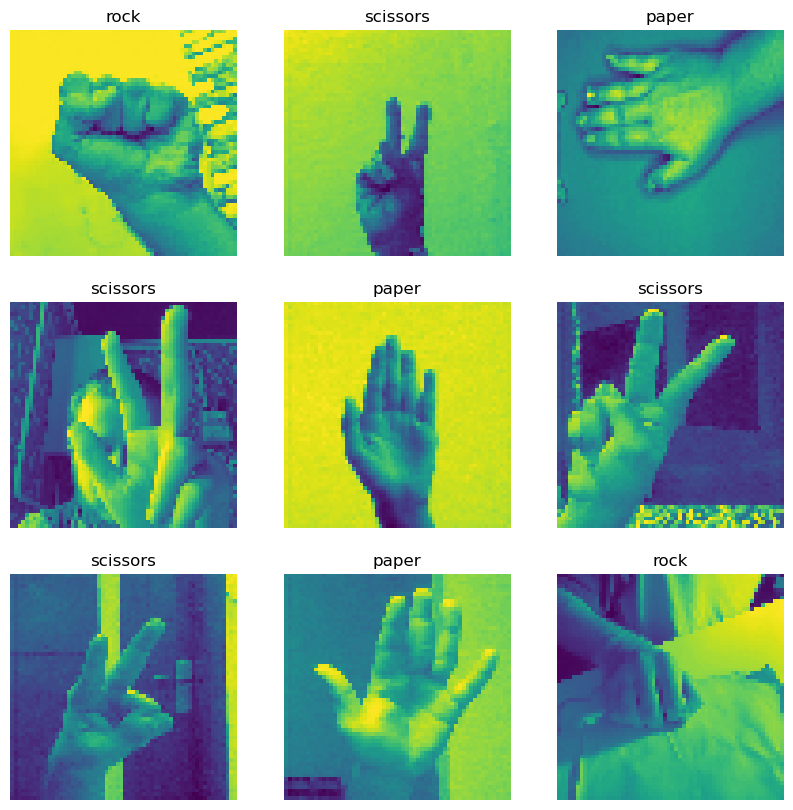

In [309]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [310]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2023-01-17 18:29:51.632766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 24 of 1000
2023-01-17 18:30:01.505795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 70 of 1000
2023-01-17 18:30:11.471689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 104 of 1000
2023-01-17 18:30:21.573225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 140 of 1000
2023-01-17 18:30:31.507839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 190 of 1000
2023-01-17 18:30:41.432404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 237 of 1000


0.0 0.9450981


2023-01-17 18:30:42.239278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


In [311]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       1)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [312]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [313]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 60, 60, 1)         0         
                                                                 
 rescaling_5 (Rescaling)     (None, 60, 60, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                  

In [314]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
249/249 [==============================] - 23s 87ms/step - loss: 0.9445 - accuracy: 0.5293 - val_loss: 1.1168 - val_accuracy: 0.4467
Epoch 2/15
249/249 [==============================] - 19s 77ms/step - loss: 0.6200 - accuracy: 0.7296 - val_loss: 1.1920 - val_accuracy: 0.4800
Epoch 3/15
249/249 [==============================] - 19s 78ms/step - loss: 0.4616 - accuracy: 0.8082 - val_loss: 1.1072 - val_accuracy: 0.4800
Epoch 4/15
249/249 [==============================] - 19s 75ms/step - loss: 0.3672 - accuracy: 0.8456 - val_loss: 1.3346 - val_accuracy: 0.4933
Epoch 5/15
249/249 [==============================] - 19s 77ms/step - loss: 0.3094 - accuracy: 0.8726 - val_loss: 1.3502 - val_accuracy: 0.4600
Epoch 6/15
249/249 [==============================] - 19s 77ms/step - loss: 0.2829 - accuracy: 0.8817 - val_loss: 1.2919 - val_accuracy: 0.4733
Epoch 7/15
249/249 [==============================] - 19s 77ms/step - loss: 0.2646 - accuracy: 0.8885 - val_loss: 1.5247 - val_accuracy:

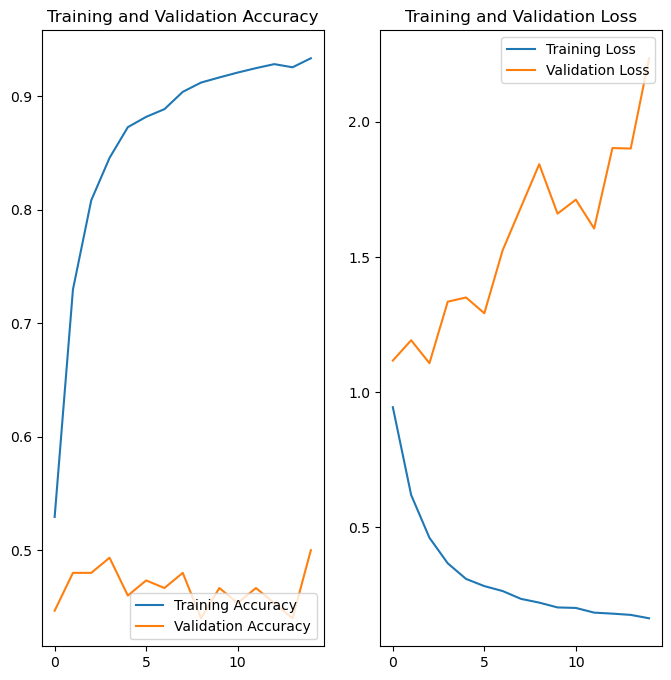

In [315]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Workpackage: Model Evaluation

Research Question:
**What is the effect of using different evaluation metrics on the appearance of the model performance?**

Research Answer:


In [316]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

def calculate_mcc(tp,tn,fp,fn):
    try:
        return (tp*tn - fp*fn)/sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except Exception as e:
        return 0

In [317]:
custom_dir = pathlib.Path('../Dataset/testing_data')
custom_rock = list(custom_dir.glob('rock/*.png'))
custom_paper = list(custom_dir.glob('paper/*.png'))
custom_scissors = list(custom_dir.glob('scissors/*.png'))

path = custom_paper[12]

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width), color_mode='grayscale'
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 94ms/step
This image most likely belongs to paper with a 99.99 percent confidence.


In [318]:


y_pred_rock = []
y_pred_paper = []
y_pred_scissors = []

tp = 0
def predict_image(path):
    img = tf.keras.utils.load_img(
        path, target_size=(img_height, img_width), color_mode='grayscale'
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    return np.argmax(score)

for path in custom_rock:
    prediction = predict_image(path)
    y_pred_rock.append(prediction)
for path in custom_paper:
    prediction = predict_image(path)
    y_pred_paper.append(prediction)
for path in custom_scissors:
    prediction = predict_image(path)
    y_pred_scissors.append(prediction)

pred = np.concatenate((y_pred_rock,y_pred_paper,y_pred_scissors), axis=0)
y_true_rock = np.full((len(y_pred_rock)),0)
y_true_paper = np.full((len(y_pred_paper)),1)
y_true_scissors = np.full((len(y_pred_scissors)),2)
truth = np.concatenate((y_true_rock,y_true_paper, y_true_scissors), axis=0)

1/1 [==============================] - 0s 17ms/step


In [319]:
matrix = confusion_matrix(y_true=truth,y_pred=pred)


#fp,tp,tn,fn for each class
tp_rock = matrix[0, 0]
tp_paper = matrix[1, 1]
tp_scissors = matrix[2, 2]
tp_total = tp_rock + tp_paper + tp_scissors

tn_rock = np.sum(matrix) - (tp_rock + matrix[0, 1] + matrix[0, 2])
tn_paper = np.sum(matrix) - (tp_paper + matrix[1, 0] + matrix[1, 2])
tn_scissors = np.sum(matrix) - (tp_scissors + matrix[2, 0] + matrix[2, 1])

fp_rock = matrix[0, 1] + matrix[0, 2]
fp_paper = matrix[1, 0] + matrix[1, 2]
fp_scissors = matrix[2, 0] + matrix[2, 1]

fn_rock = matrix[1, 0] + matrix[2, 0]
fn_paper = matrix[0, 1] + matrix[2, 1]
fn_scissors = matrix[0, 2] + matrix[1, 2]

#confusion matrix for each class
confusion_matrix_rock = np.array([[tn_rock, fp_rock], [fn_rock, tp_rock]])
confusion_matrix_paper = np.array([[tn_paper, fp_paper], [fn_paper, tp_paper]])
confusion_matrix_scissors = np.array([[tn_scissors, fp_scissors], [fn_scissors, tp_scissors]])

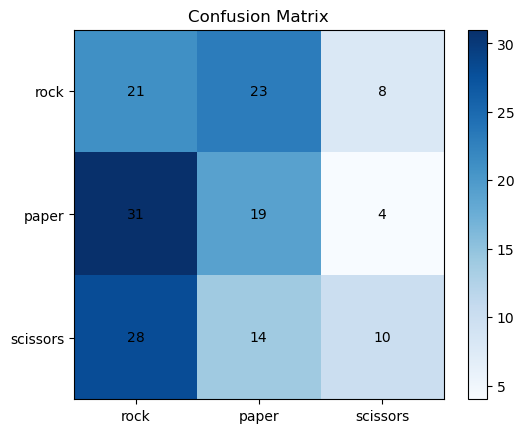

In [320]:
labels = ['rock', 'paper', 'scissors']

fig, ax = plt.subplots()

image = ax.imshow(matrix, cmap='Blues')
for i in range(3):
    for j in range(3):
        ax.text(j, i, matrix[i][j], ha='center', va='center', color='black')

ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_title('Confusion Matrix')
fig.colorbar(image)
plt.show()

In [321]:
accuracy_rock = accuracy_score(y_true=y_true_rock,y_pred=y_pred_rock)
accuracy_paper = accuracy_score(y_true=y_true_paper,y_pred=y_pred_paper)
accuracy_scissors = accuracy_score(y_true=y_true_scissors,y_pred=y_pred_scissors)
accuracy_total = accuracy_score(y_true=truth,y_pred=pred)
accuracy_array = [accuracy_rock,accuracy_paper,accuracy_scissors]
print(accuracy_rock)
print(accuracy_paper)
print(accuracy_scissors)
print(accuracy_total)

precision_array, recall_array, f1_array, _ = precision_recall_fscore_support(y_true=truth,y_pred=pred)
precision_rock = precision_array[0]
precision_paper = precision_array[1]
precision_scissors = precision_array[2]

recall_rock = recall_array[0]
recall_paper = recall_array[1]
recall_scissors = recall_array[2]

f1_rock = f1_array[0]
f1_paper = f1_array[1]
f1_scissors = f1_array[2]

mcc_rock = calculate_mcc(tp_rock,tn_rock,fp_rock,fn_rock)
mcc_paper = calculate_mcc(tp_paper,tn_paper,fp_paper,fn_paper)
mcc_scissors = calculate_mcc(tp_scissors,tn_scissors,fp_scissors,fn_scissors)

mcc_array = [mcc_rock,mcc_paper,mcc_scissors]

0.40384615384615385
0.35185185185185186
0.19230769230769232
0.31645569620253167


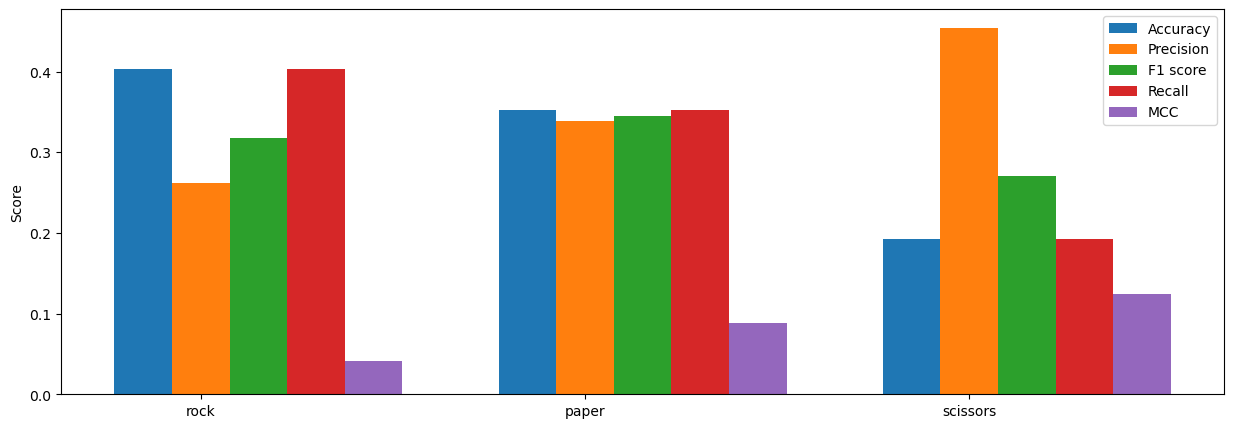

In [322]:
fig, ax = plt.subplots(figsize=(15,5))
x = np.arange(3)
ax.bar(x - 0.15, accuracy_array, 0.15, label='Accuracy')
ax.bar(x, precision_array, 0.15, label='Precision')
ax.bar(x + 0.15, f1_array, 0.15, label='F1 score')
ax.bar(x+0.3, recall_array, 0.15, label='Recall')
ax.bar(x + 0.45, mcc_array, 0.15, label='MCC')
ax.set_xticks(x)
ax.set_xticklabels(['rock', 'paper', 'scissors'])
ax.set_ylabel('Score')
ax.legend()
plt.show()

In [323]:
from sklearn.metrics import matthews_corrcoef, ConfusionMatrixDisplay


def plotMetrics(y_true_rock, y_true_paper, y_true_scissors, y_pred_rock, y_pred_paper, y_pred_scissors):
    full_truth = np.concatenate((y_true_rock,y_true_paper,y_true_scissors), axis=0)
    full_pred = np.concatenate((y_pred_rock,y_pred_paper,y_pred_scissors), axis=0)
    matrix = confusion_matrix(y_true=full_truth,y_pred=full_pred)

    #fp,tp,tn,fn for each class
    tp_rock = matrix[0, 0]
    tp_paper = matrix[1, 1]
    tp_scissors = matrix[2, 2]
    tp_total = tp_rock + tp_paper + tp_scissors

    tn_rock = np.sum(matrix) - (tp_rock + matrix[0, 1] + matrix[0, 2])
    tn_paper = np.sum(matrix) - (tp_paper + matrix[1, 0] + matrix[1, 2])
    tn_scissors = np.sum(matrix) - (tp_scissors + matrix[2, 0] + matrix[2, 1])

    fp_rock = matrix[0, 1] + matrix[0, 2]
    fp_paper = matrix[1, 0] + matrix[1, 2]
    fp_scissors = matrix[2, 0] + matrix[2, 1]

    fn_rock = matrix[1, 0] + matrix[2, 0]
    fn_paper = matrix[0, 1] + matrix[2, 1]
    fn_scissors = matrix[0, 2] + matrix[1, 2]

    #confusion matrix for each class
    confusion_matrix_rock = np.array([[tn_rock, fp_rock], [fn_rock, tp_rock]])
    confusion_matrix_paper = np.array([[tn_paper, fp_paper], [fn_paper, tp_paper]])
    confusion_matrix_scissors = np.array([[tn_scissors, fp_scissors], [fn_scissors, tp_scissors]])

    labels = ['rock', 'paper', 'scissors']


    fig, ax = plt.subplots()

    image = ax.imshow(matrix, cmap='Blues')
    for i in range(3):
        for j in range(3):
            ax.text(j, i, matrix[i][j], ha='center', va='center', color='black')

    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('Confusion Matrix')
    fig.colorbar(image)
    plt.show()

    accuracy_rock = accuracy_score(y_true=y_true_rock,y_pred=y_pred_rock)
    accuracy_paper = accuracy_score(y_true=y_true_paper,y_pred=y_pred_paper)
    accuracy_scissors = accuracy_score(y_true=y_true_scissors,y_pred=y_pred_scissors)
    accuracy_total = accuracy_score(y_true=full_truth,y_pred=full_pred)
    accuracy_array = [accuracy_rock,accuracy_paper,accuracy_scissors]

    precision_array, recall_array, f1_array, _ = precision_recall_fscore_support(y_true=full_truth,y_pred=full_pred)
    precision_rock = precision_array[0]
    precision_paper = precision_array[1]
    precision_scissors = precision_array[2]

    recall_rock = recall_array[0]
    recall_paper = recall_array[1]
    recall_scissors = recall_array[2]

    f1_rock = f1_array[0]
    f1_paper = f1_array[1]
    f1_scissors = f1_array[2]

    mcc_rock = calculate_mcc(tp_rock,tn_rock,fp_rock,fn_rock)
    mcc_paper = calculate_mcc(tp_paper,tn_paper,fp_paper,fn_paper)
    mcc_scissors = calculate_mcc(tp_scissors,tn_scissors,fp_scissors,fn_scissors)
    mcc_array = [mcc_rock,mcc_paper,mcc_scissors]

    fig, ax = plt.subplots(figsize=(15,5))
    x = np.arange(3)
    ax.bar(x - 0.15, accuracy_array, 0.15, label='Accuracy',color='#FFFB7A')
    ax.bar(x, precision_array, 0.15, label='Precision',color='#65EBBB')
    ax.bar(x + 0.15, f1_array, 0.15, label='F1 score',color='#E365EB')
    ax.bar(x+0.3, recall_array, 0.15, label='Recall',color='#7398FF')
    ax.bar(x + 0.45, mcc_array, 0.15, label='MCC',color='#FF9966')
    ax.set_xticks(x)
    ax.set_xticklabels(['rock', 'paper', 'scissors'])
    ax.set_ylabel('Score')
    ax.legend()
    plt.show()


    return


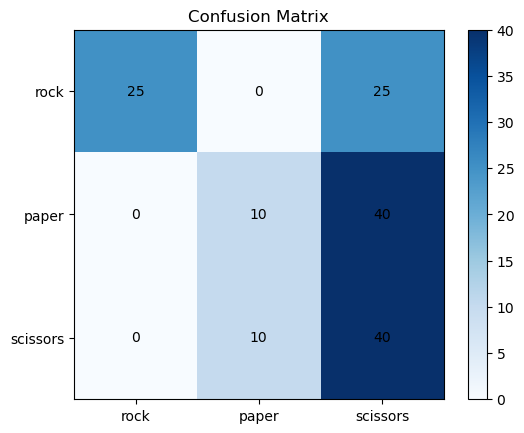

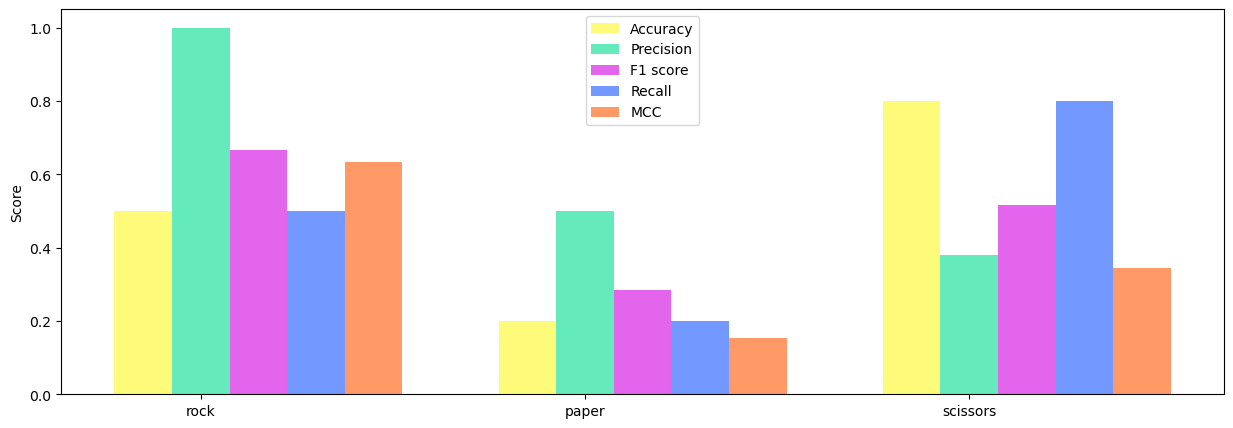

In [324]:
test_true_rock = np.full((50),0)
test_true_paper = np.full((50),1)
test_true_scissors = np.full((50),2)
test_pred_rock = np.concatenate((np.full((25),0),np.random.choice([2], size=25)))
test_pred_paper = np.concatenate((np.full((10),1),np.random.choice([2], size=40)))
test_pred_scissors = np.concatenate(((np.full((40),2)),(np.random.choice([1], size=10))))
plotMetrics(test_true_rock, test_true_paper, test_true_scissors,test_pred_rock,test_pred_paper, test_pred_scissors)

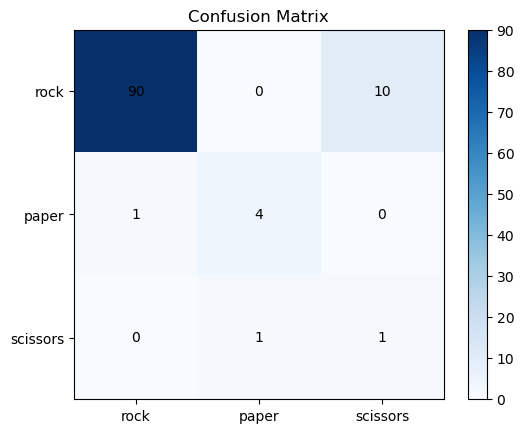

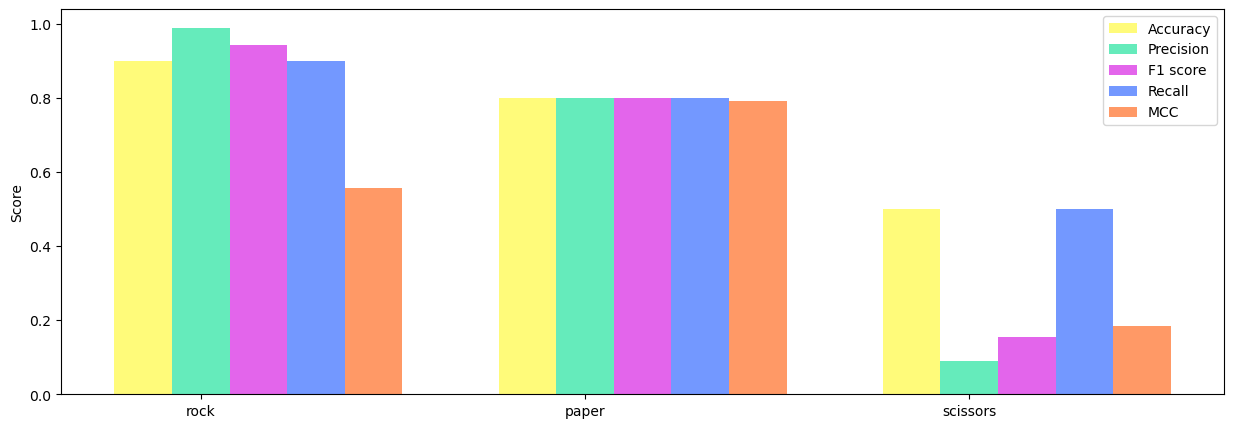

In [325]:
test_true_rock = np.full((100),0)
test_true_paper = np.full((5),1)
test_true_scissors = np.full((2),2)
test_pred_rock = np.concatenate((np.full((90),0),np.random.choice([2], size=10)))
test_pred_paper = np.concatenate((np.full((4),1),np.random.choice([0], size=1)))
test_pred_scissors = np.concatenate(((np.full((1),2)),(np.random.choice([1], size=1))))
plotMetrics(test_true_rock, test_true_paper, test_true_scissors,test_pred_rock,test_pred_paper, test_pred_scissors)

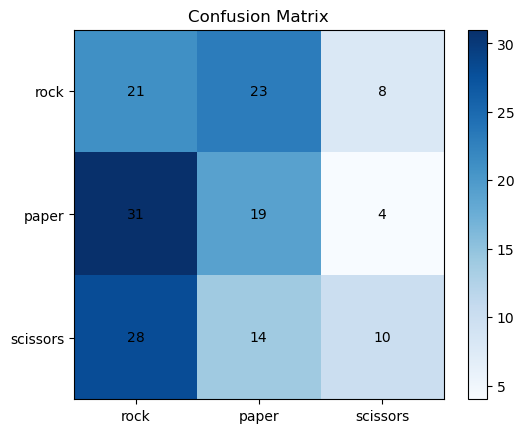

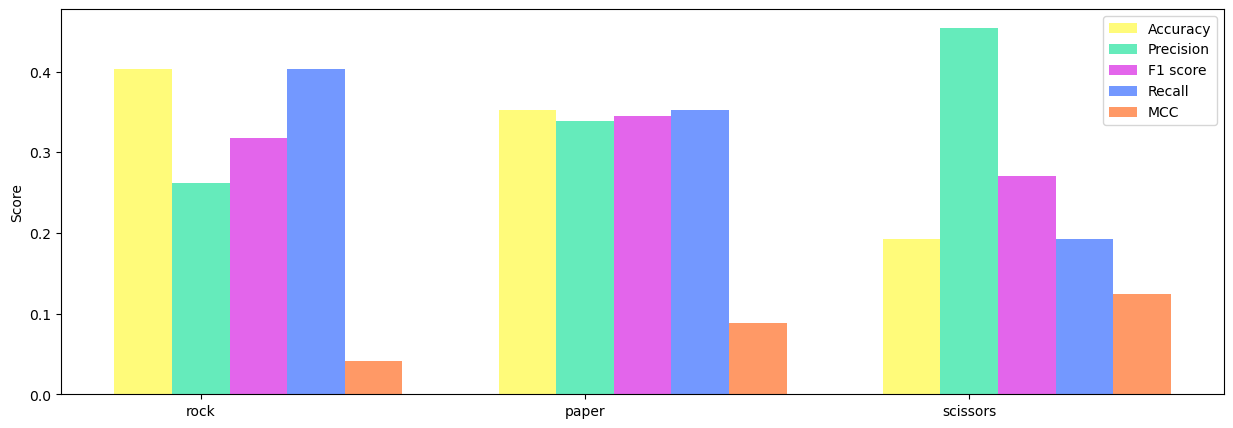

In [326]:
plotMetrics(y_true_rock, y_true_paper, y_true_scissors,y_pred_rock,y_pred_paper, y_pred_scissors)